Try indep sites on two different paths of the tree

In [84]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
import numpy as np
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from adabmDCA.sampling import get_sampler
import random

File names for data

In [44]:
import importlib
importlib.reload(selex_dca)

<module 'selex_dca' from '/home/scrotti/Aptamer2025py/experiments/../selex_dca.py'>

In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N", "R02F", "R02S", "R02SF"]

In [3]:
device = torch.device("cpu")
dtype = torch.float32

Extract sequences and compute 1st and 2nd moment statistics

In [4]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [5]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=device) for seq in sequences]
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh]).to(device)

In [6]:
paths = [np.array([1, 2]), np.array([1, 3]), np.array([1, 4]), np.array([1, 5])]
n_paths = len(paths)
path_labels = ['norm A, norm W', 'fast A, norm W', 'norm A, high W', 'fast A, high W']

In [17]:
freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
    *[utils.frequences_from_sequences(seq, pseudo_count=0, dtype=dtype) for seq in sequences])

fi = torch.stack(freq_single_tuple).to(device)  # n_rounds, L, q
fij = torch.stack(freq_pair_tuple).to(device)     # n_rounds, L, q, L, q

n_rounds, L, q = fi.size()

In [19]:
sequences_oh_paths = [[sequences_oh[pp] for pp in p] for p in paths]
fi_paths = [fi[p] for p in paths]
fij_paths = [fij[p] for p in paths]
total_reads_paths = [total_reads[p] for p in paths]

In [21]:
sampler_alg = "metropolis"
sampler = torch.jit.script(get_sampler(sampler_alg))

 0.00%[                                    ] Epoch: 0/6000 [00:00]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Finished 2 of 4


 0.00%[                                    ] Epoch: 0/6000 [00:00]

Finished 3 of 4


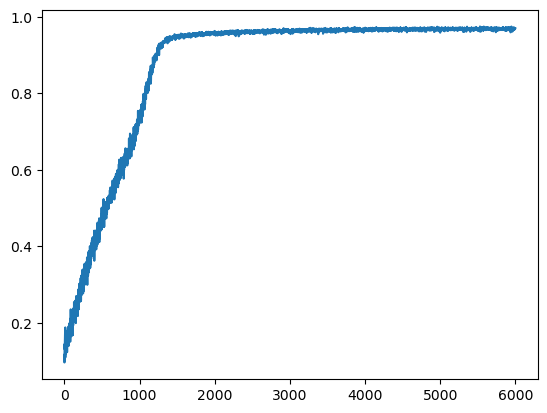

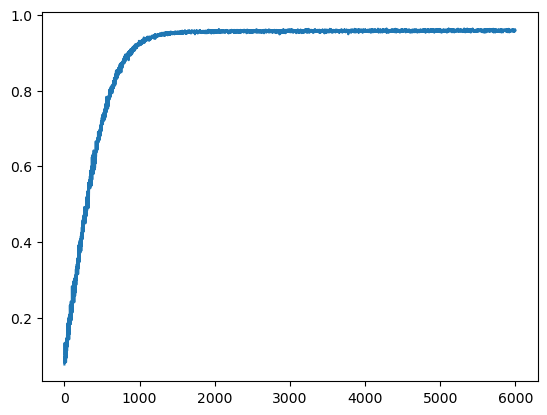

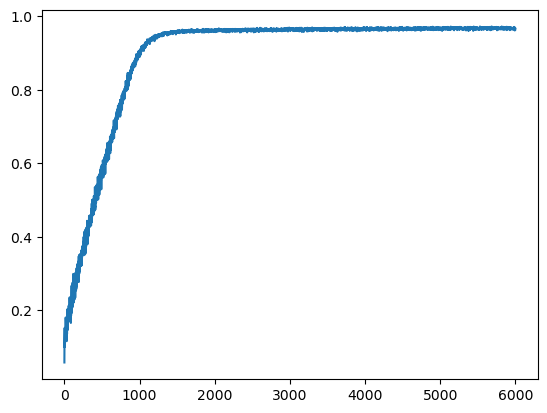

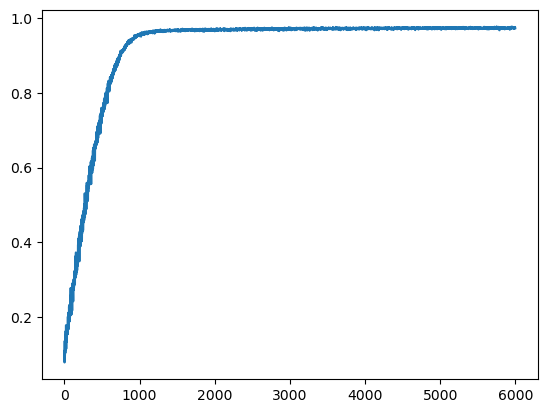

In [55]:
params_paths = []
histories_paths = []
chains_paths = []

max_epochs = 6000

for i in range(len(paths)):
    fi_path = fi_paths[i]
    fij_path = fij_paths[i]
    total_reads_path = total_reads_paths[i]
    history = selex_dca.init_history()
    params = selex_dca.init_parameters(fi_path)
    n_rounds = len(total_reads_path)
    chains = selex_dca.init_chains(n_rounds, n_chains, L, q, device, dtype)
    mask = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
    mask[torch.arange(L), :, torch.arange(L), :] = 0
    
    chains, params, history = selex_dca.train(
        sampler,
        chains,
        fi = fi_path,
        fij = fij_path,
        total_reads = total_reads_path,
        params = params,
        lr = 1e-2,    
        max_epochs = max_epochs,
        target_pearson = 1,
        nsweeps = 10,
        mask_ps = mask,
        mask_Ns0 = mask,
        history = history,
        progress_bar = True
    )

    params_paths.append(params)
    histories_paths.append(history)
    chains_paths.append(chains)

    fig, ax = plt.subplots()
    ax.plot(history["pearson"])
    fig.savefig(f'pearson_{i}.png')

    print(f'Finished {i+1} of {len(paths)}')

In [121]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/scrotti/Aptamer2025py/experiments/../utils.py'>

In [122]:
def zerosum(params):
    params_zerosum = {}
    params_zerosum["couplings_Ns0"], params_zerosum["bias_Ns0"] = utils.set_zerosum_gauge(params["couplings_Ns0"], params["bias_Ns0"])
    params_zerosum["couplings_ps"], params_zerosum["bias_ps"] = utils.set_zerosum_gauge(params["couplings_ps"], params["bias_ps"])
    return params_zerosum

In [123]:
params_paths_zerosum = [zerosum(p) for p in params_paths]

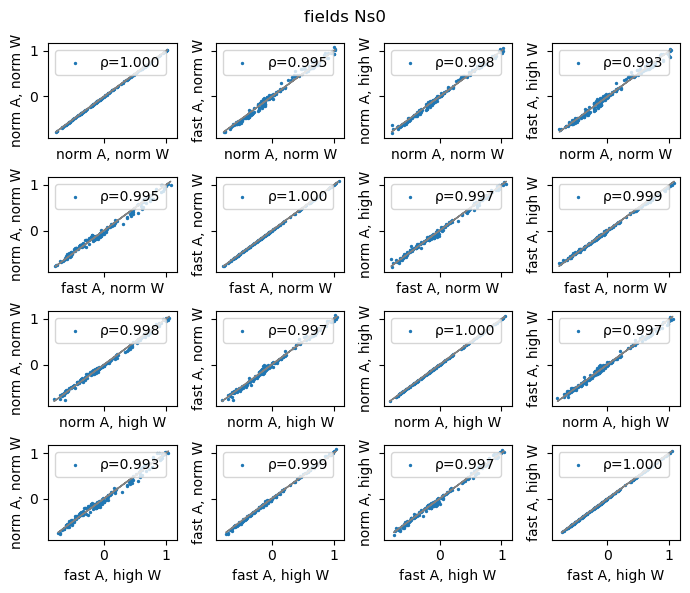

In [124]:
fig, axes = plt.subplots(n_paths, n_paths, sharex=True, sharey=True, figsize=(7,6))

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = params_paths_zerosum[i]["bias_Ns0"].view(-1)
        y = params_paths_zerosum[j]["bias_Ns0"].view(-1)
        rho = torch.corrcoef(torch.stack((x,y)))[0,1].item()
        ax.scatter(x, y, s=2, label=f'ρ={rho:.3f}')
        ax.legend()
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('fields Ns0')
fig.tight_layout()

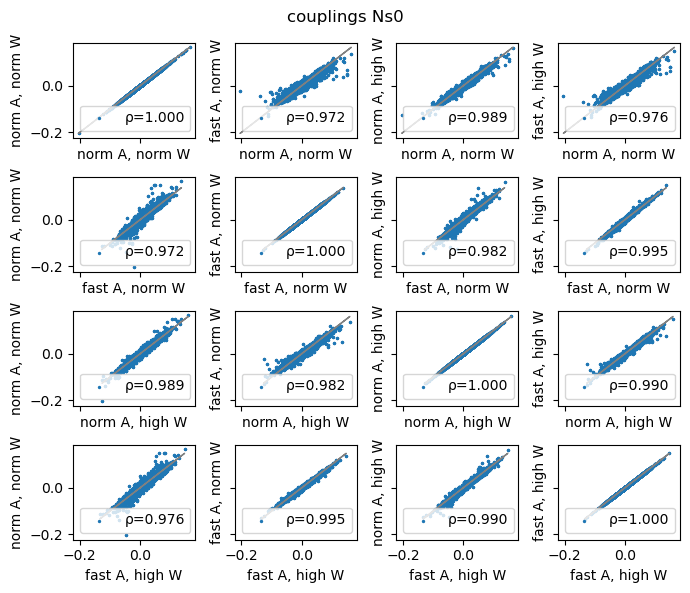

In [125]:
fig, axes = plt.subplots(n_paths, n_paths, sharex=True, sharey=True, figsize=(7,6))

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = params_paths_zerosum[i]["couplings_Ns0"].view(-1)
        y = params_paths_zerosum[j]["couplings_Ns0"].view(-1)
        rho = torch.corrcoef(torch.stack((x,y)))[0,1].item()
        ax.scatter(x, y, s=2, label=f'ρ={rho:.3f}')
        ax.legend()
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('couplings Ns0')
fig.tight_layout()

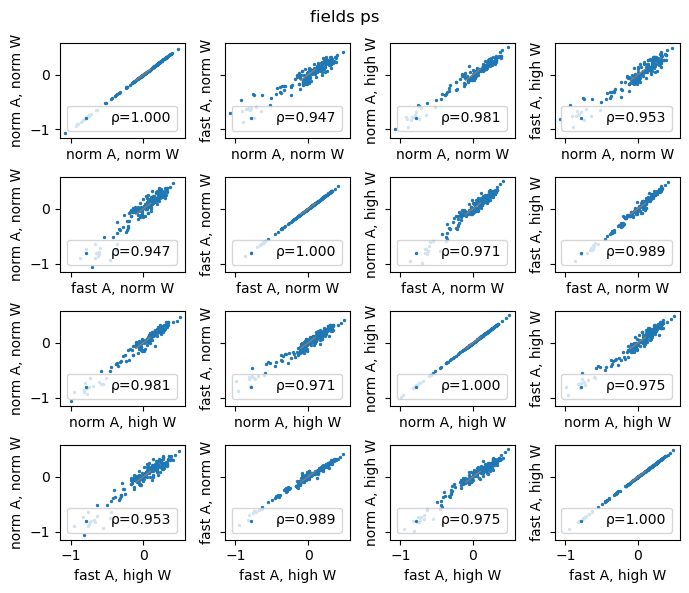

In [126]:
fig, axes = plt.subplots(n_paths, n_paths, sharex=True, sharey=True, figsize=(7,6))
lims = [-0.1,0.1]

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = params_paths_zerosum[i]["bias_ps"].view(-1)
        y = params_paths_zerosum[j]["bias_ps"].view(-1)
        rho = torch.corrcoef(torch.stack((x,y)))[0,1].item()
        ax.scatter(x, y, s=2, label=f'ρ={rho:.3f}')
        ax.legend()
        ax.plot(lims, lims, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('fields ps')
fig.tight_layout()

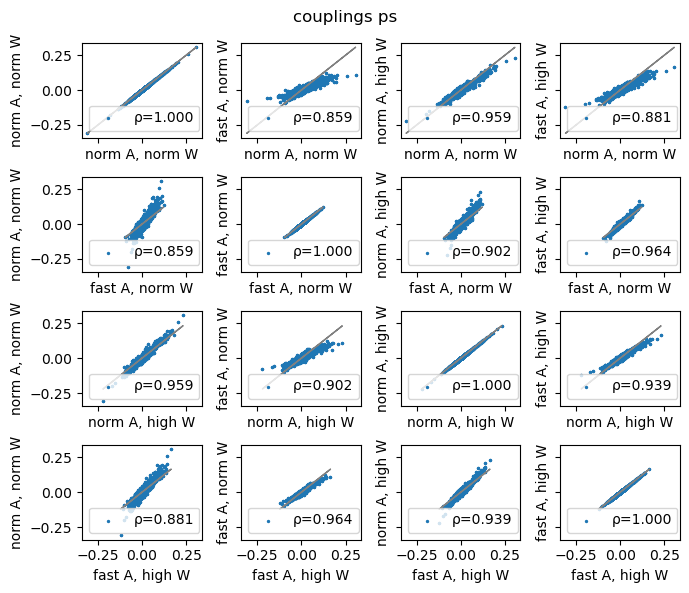

In [128]:
fig, axes = plt.subplots(n_paths, n_paths, sharex=True, sharey=True, figsize=(7,6))

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = params_paths_zerosum[i]["couplings_ps"].view(-1)
        y = params_paths_zerosum[j]["couplings_ps"].view(-1)
        rho = torch.corrcoef(torch.stack((x,y)))[0,1].item()
        ax.scatter(x, y, s=2, label=f'ρ={rho:.3f}')
        ax.legend()
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('couplings ps')
fig.tight_layout()

In [129]:
X = sequences_oh[0]

In [130]:
logNs0_paths = []
for i in range(len(paths)):
    params = params_paths_zerosum[i]
    logNs0 = adabmDCA.statmech.compute_energy(X, {"bias": params["bias_Ns0"], "coupling_matrix": params["couplings_Ns0"]})
    logNs0_paths.append(logNs0)
    print(f"finished {i+1}-th path")

finished 1-th path
finished 2-th path
finished 3-th path
finished 4-th path


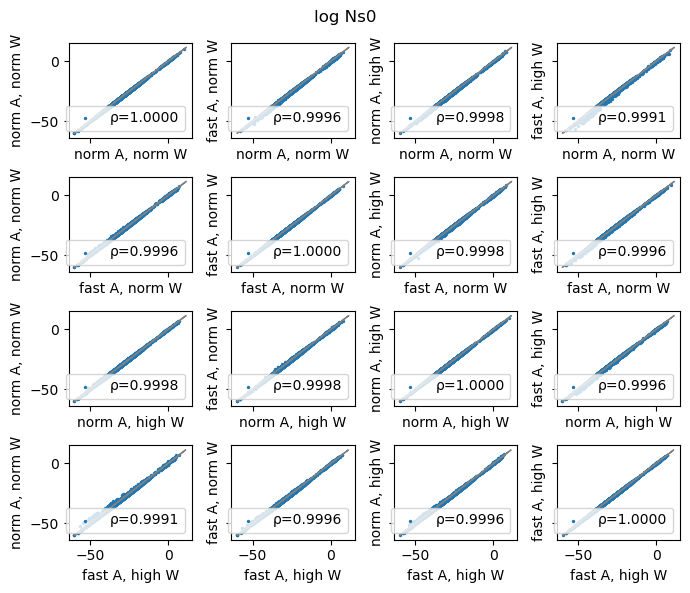

In [131]:
fig, axes = plt.subplots(n_paths, n_paths, 
                         sharex=True, sharey=True, figsize=(7,6)
                        )
N = 10**4

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = logNs0_paths[i]
        y = logNs0_paths[j]
        idx = random.sample(range(len(x)), min(N, len(x)))
        rho = torch.corrcoef(torch.stack((x[idx],y[idx])))[0,1].item()
        ax.scatter(x[idx], y[idx], s=2, label=f'ρ={rho:.4f}')
        ax.legend(loc='lower right')
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('log Ns0')
fig.tight_layout()

In [142]:
X = sequences_oh[0]

In [143]:
logps_paths = []
for i in range(len(paths)):
    params = params_paths_zerosum[i]
    logps = adabmDCA.statmech.compute_energy(X, {"bias": params["bias_ps"], "coupling_matrix": params["couplings_ps"]})
    logps_paths.append(logps)
    print(f"finished {i+1}-th path")

finished 1-th path
finished 2-th path
finished 3-th path
finished 4-th path


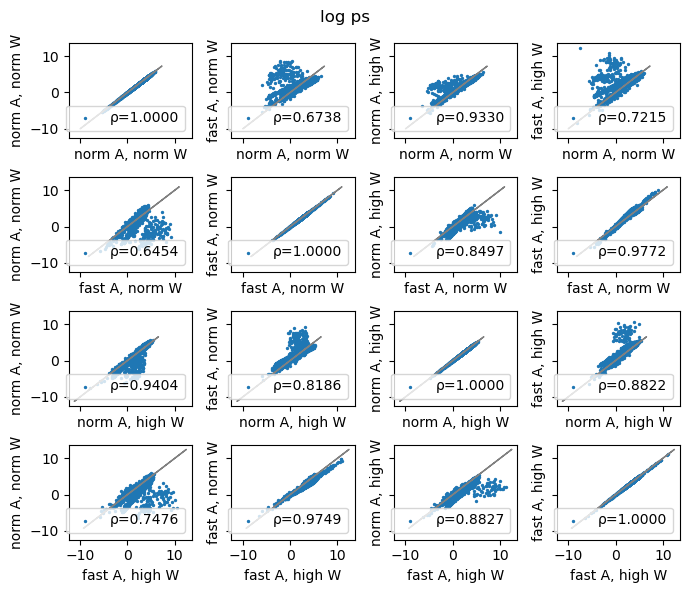

In [157]:
fig, axes = plt.subplots(n_paths, n_paths, 
                         sharex=True, sharey=True, figsize=(7,6)
                        )
N = 10**4

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = logps_paths[i]
        y = logps_paths[j]
        idx = random.sample(range(len(x)), min(N, len(x)))
        rho = torch.corrcoef(torch.stack((x[idx],y[idx])))[0,1].item()
        ax.scatter(x[idx], y[idx], s=2, label=f'ρ={rho:.4f}')
        ax.legend(loc='lower right')
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('log ps')
fig.tight_layout()

Check zerosum:

In [145]:
logps_paths_nozs = []
for i in range(len(paths)):
    params = params_paths[i]
    logps = adabmDCA.statmech.compute_energy(X, {"bias": params["bias_ps"], "coupling_matrix": params["couplings_ps"]})
    logps_paths_nozs.append(logps)
    print(f"finished {i+1}-th path")

finished 1-th path
finished 2-th path
finished 3-th path
finished 4-th path


In [147]:
for i in range(len(paths)):
    print((logps_paths_nozs[0] - logps_paths[0]).abs().max())

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
